# Collaborative Filtering using fastai
---

In [2]:
from fastai.collab import *

## Load Movielens Data

### Download Data

In [11]:
! touch ~/.fastai/data/ml-100k.zip

In [12]:
! curl 'http://files.grouplens.org/datasets/movielens/ml-100k.zip' --output ~/.fastai/data/ml-100k.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4808k  100 4808k    0     0  2394k      0  0:00:02  0:00:02 --:--:-- 2394k


In [14]:
! unzip ~/.fastai/data/ml-100k.zip -d ~/.fastai/data/

Archive:  /home/jupyter/.fastai/data/ml-100k.zip
   creating: /home/jupyter/.fastai/data/ml-100k/
  inflating: /home/jupyter/.fastai/data/ml-100k/allbut.pl  
  inflating: /home/jupyter/.fastai/data/ml-100k/mku.sh  
  inflating: /home/jupyter/.fastai/data/ml-100k/README  
  inflating: /home/jupyter/.fastai/data/ml-100k/u.data  
  inflating: /home/jupyter/.fastai/data/ml-100k/u.genre  
  inflating: /home/jupyter/.fastai/data/ml-100k/u.info  
  inflating: /home/jupyter/.fastai/data/ml-100k/u.item  
  inflating: /home/jupyter/.fastai/data/ml-100k/u.occupation  
  inflating: /home/jupyter/.fastai/data/ml-100k/u.user  
  inflating: /home/jupyter/.fastai/data/ml-100k/u1.base  
  inflating: /home/jupyter/.fastai/data/ml-100k/u1.test  
  inflating: /home/jupyter/.fastai/data/ml-100k/u2.base  
  inflating: /home/jupyter/.fastai/data/ml-100k/u2.test  
  inflating: /home/jupyter/.fastai/data/ml-100k/u3.base  
  inflating: /home/jupyter/.fastai/data/ml-100k/u3.test  
  inflating: /home/jupyter/.fas

In [23]:
path = Path('/home/jupyter/.fastai/data/ml-100k')

In [24]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/ml-100k/u.genre'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/u2.base'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/u3.test'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/allbut.pl'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/u.item'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/u5.test'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/ua.base'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/u4.base'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/ub.test'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/u5.base'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/u1.base'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/u.info'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/u1.test'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/u.data'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/README'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/u4.test'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/u.user'),
 PosixPath('/home

### Read into DataFrame

In [25]:
ratings = pd.read_csv(path/'u.data', sep='\t', header=None, names=['userID', 'itemID','rating', 'timestamp'])
ratings.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [32]:
movies = pd.read_csv(path/'u.item', sep='|', header=None,  encoding='latin-1',names=['itemID', 'title', *[f'col_{i}' for i in range(22)]])
movies.head()

,itemID,title,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,...,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19,col_20,col_21
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [34]:
movies_ratings = ratings.merge(movies[['itemID', 'title']])
movies_ratings.head()

,userID,itemID,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


### Create DataBunch

In [64]:
data = CollabDataBunch.from_df(movies_ratings, valid_pct=0.1,
                               user_name='userID', item_name='itemID', rating_name='rating')
data.show_batch()

userID,itemID,target
13,842,2.0
206,682,3.0
42,433,2.0
566,117,4.0
227,324,4.0


In [79]:
ratings_range = [0,5,5]

## Train Collaborative Filtering Learner

In [113]:
learner = collab_learner(data, n_factors=50, y_range=ratings_range, metrics=accuracy_thresh)

In [114]:
learner.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1671, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1671, 1)
)

In [115]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


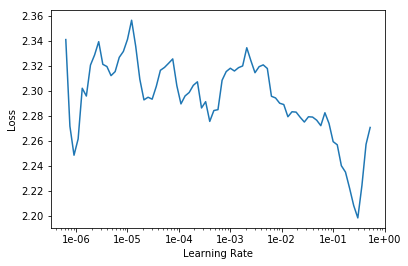

In [116]:
learner.recorder.plot(skip_end=15)

In [117]:
lr =1e-3

In [118]:
learner.fit_one_cycle(3, lr)

epoch,train_loss,valid_loss,accuracy_thresh,time
1,1.101477,1.079580,0.059100,00:07
2,0.926721,0.909422,0.059100,00:08
3,0.908453,0.899262,0.059100,00:07


In [119]:
learner.fit_one_cycle(3, lr)

epoch,train_loss,valid_loss,accuracy_thresh,time
1,0.831737,0.880032,0.059100,00:07
2,0.840412,0.855513,0.059100,00:08
3,0.788622,0.851945,0.059100,00:07


In [120]:
learner.save('dotprod')

## Interpretation